In [130]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, Dense, UpSampling2D, Reshape
from keras.layers import Conv2DTranspose, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.datasets import cifar10
%matplotlib inline
import matplotlib.pylab as plt 
from tqdm import tnrange
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras import activations
from glob import glob
import numpy as np

In [131]:
img_rows = 224
img_cols = 224
channel = 3
classes = 4
depth = 64
dropout = 0.4

In [132]:
input_shape = (img_rows, img_cols, channel)

discriminator = Sequential()

discriminator.add(Conv2D(depth*1, 5, strides=2, 
                         input_shape=input_shape,padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*2, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*4, 5, strides=2, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(depth*8, 5, strides=1, padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(dropout))

discriminator.add(Flatten())
discriminator.add(Dense(classes + 1))
discriminator.add(Activation('softmax'))

#discriminator.summary()

In [133]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_model = Sequential()
discriminator_model.add(discriminator)

discriminator_model.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['accuracy'])

In [134]:
dropout = 0.4
depth = 64+64+64+64
dim = 56

In [135]:
generator = Sequential()

generator.add(Dense(dim*dim*depth, input_dim=100 + classes))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))
generator.add(Reshape((dim, dim, depth)))
generator.add(Dropout(dropout))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(UpSampling2D())
generator.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
generator.add(BatchNormalization(momentum=0.9))
generator.add(Activation('relu'))

generator.add(Conv2DTranspose(3, 5, padding='same'))
generator.add(Activation('sigmoid'))

#generator.summary()

In [136]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

adversarial_model = Sequential()
adversarial_model.add(generator)
discriminator.trainable = False
adversarial_model.add(discriminator)

adversarial_model.compile(loss='categorical_crossentropy', 
                          optimizer=optimizer,
                          metrics=['accuracy'])
#adversarial_model.summary() 

In [137]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2

In [138]:
Healthy = []
for filename in glob.glob('/content/drive/MyDrive/#Rice_dataset#/h_672_672/*.jpg'):
  img = Image.open(filename)
  img = np.array(img)
  image = cv2.resize(img, (224, 224), interpolation= Image.ANTIALIAS) #Image.ANTIALIAS, cv2.INTER_CUBIC
  Healthy.append(image)

In [139]:
BrownSpot = []
for filename in glob.glob('/content/drive/MyDrive/#Rice_dataset#/b_672_672/*.jpg'):
  img = Image.open(filename)
  img = np.array(img)
  image = cv2.resize(img, (224, 224), interpolation= Image.ANTIALIAS) #Image.ANTIALIAS, cv2.INTER_CUBIC
  BrownSpot.append(image)

In [44]:
Hispa = []
for filename in glob.glob('/content/drive/MyDrive/#Rice_dataset#/hispa_672_672/*.jpg'):
  img = Image.open(filename)
  img = np.array(img)
  image = cv2.resize(img, (224, 224), interpolation= Image.ANTIALIAS) #Image.ANTIALIAS, cv2.INTER_CUBIC
  Hispa.append(image)

In [140]:
LeafBlast = []
for filename in glob.glob('/content/drive/MyDrive/#Rice_dataset#/L_672_672/*.jpg'):
  img = Image.open(filename)
  img = np.array(img)
  image = cv2.resize(img, (224, 224), interpolation= Image.ANTIALIAS) #Image.ANTIALIAS, cv2.INTER_CUBIC
  LeafBlast.append(image)

In [141]:
Healthy_label = []
for i in range(len(Healthy)):
  Healthy_label.append([0, 0, 0, 1])

BrownSpot_label = []
for i in range(len(BrownSpot)):
  BrownSpot_label.append([0, 0, 1, 0])

Hispa_label = []
for i in range(len(Hispa)):
  Hispa_label.append([0, 1, 0, 0])

LeafBlast_label = []
for i in range(len(LeafBlast)):
  LeafBlast_label.append([1, 0, 0, 0])

In [142]:
x_train = np.concatenate((Healthy, BrownSpot, Hispa, LeafBlast))
y_train = np.concatenate((Healthy_label, BrownSpot_label, Hispa_label, LeafBlast_label))

In [143]:
def normalize(images):
    images=images.astype('float32')
    if images.max() > 1.0:
        images/=255.0
    return images

In [144]:
def one_hot(labels):
    enc = OneHotEncoder()
    return enc.fit_transform(y_train).toarray()

In [145]:
x_train = normalize(x_train)
#y_train = one_hot(y_train)

In [146]:
def create_generator_noise(batch_size):
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    sampling = np.random.randint(classes, size=batch_size)
    noise_labels = np.zeros((batch_size, classes))
    noise_labels[np.arange(batch_size), sampling] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input, noise_labels

In [147]:
def create_generator_noise_by_label(labels):
    noise = np.random.uniform(-1.0, 1.0, size=[len(labels), 100])

    noise_labels = np.zeros((len(labels), classes))
    noise_labels[np.arange(len(labels)), labels] = 1
    noise_input = np.concatenate((noise, noise_labels), axis=1)
    
    return noise_input

In [148]:
def train(batch_size=64, train_steps=150000):
    discriminator_losses = []
    adversarial_losses = []
    sample_images = []
    
    for i in tnrange(train_steps):
        # Select a random sample from the training data and the labels
        sample_idx = np.random.randint(0, x_train.shape[0], size=batch_size)
        images_train = x_train[sample_idx, :, :, :]
        labels_train = y_train[sample_idx]
        labels_train = np.concatenate((labels_train, np.zeros(shape=(batch_size, 1))), axis=1)
        
        # Create noise in range -1 to 1 and random labels as input for the generator to generate the fake images
        noise_input, _ = create_generator_noise(batch_size)
        images_fake = generator.predict(noise_input)
        
        # Create input by concatenate both real and fake images and assigning the respective labels
        labels_fake = np.zeros(shape=(batch_size, classes+1))
        labels_fake[:,-1] = 1
        
        input_data   = np.concatenate((images_train, images_fake))
        input_labels = np.concatenate((labels_train, labels_fake))

        discriminator_loss = discriminator_model.train_on_batch(input_data, input_labels)
        
        # Train the adversarial model to generate better images
        noise_input, noise_labels = create_generator_noise(batch_size)
        noise_labels = np.concatenate((noise_labels, np.zeros(shape=(batch_size, 1))), axis=1)
        
        adversarial_loss = adversarial_model.train_on_batch(noise_input, noise_labels)
        
        discriminator_losses.append(discriminator_loss)
        adversarial_losses.append(adversarial_loss)
        
        if i % 100 == 0:
            labels = [1]
            noise = create_generator_noise_by_label(labels)
            fake_images = generator.predict(noise)
            sample_images.append(fake_images[0])
    
    return discriminator_losses, adversarial_losses, sample_images

In [ ]:
discriminator_losses, adversarial_losses, sample_images  = train(train_steps=150000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/150000 [00:00<?, ?it/s]

In [66]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

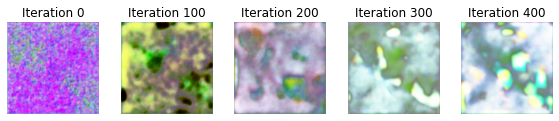

In [67]:
plt.figure(figsize=(20,40))
for i, fake_image in enumerate(sample_images, 0):
    plt.subplot(20, 10, i+1)
    plt.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)))
    plt.title("Iteration %d" % (i * 100))
    plt.axis('off')

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(np.array(discriminator_losses)[:, 0])
plt.title("Discriminator Losses")

plt.subplot(2,2,2)
plt.plot(np.array(discriminator_losses)[:, 1])
plt.title("Discriminator Accuracy")

plt.subplot(2,2,3)
plt.plot(np.array(adversarial_losses)[:, 0], color='darkorange')
plt.title("Adveserial Losses")

plt.subplot(2,2,4)
plt.plot(np.array(adversarial_losses)[:, 1], color='darkorange')
plt.title("Adveserial Accuracy")

In [69]:
label_names = ["Healthy", "BrownSpot", "Hispa", "LeafBlast"]

In [ ]:
'''
from matplotlib import pyplot

if label_names[0] == 'Healthy':
  plt.savefig()

pyplot.savefig(location_img + str(count)+".jpg")
re_size=224
image = cv2.imread(location_img + str(count)+".jpg")
image = cv2.resize(image, (re_size,re_size), interpolation=cv2.INTER_CUBIC)

train = []
j=0
k=0

for i in range(len(data)):
  single= data.iloc[i,1:64]
  if i<740:
    j+=1
    train.append(cwt_function(single,1,"/content/drive/My Drive/cwt_image/class1_test_left/",j))
  else:
    k+=1
    train.append(cwt_function(single,2,"/content/drive/My Drive/cwt_image/class2_test_right/",k))
np.save("test_Aep.npy",train)
'''

In [109]:
def sample_labels(size):
    labels = []
    for label, _ in enumerate(label_names):
        for sample_size in range(size):
            labels.append(label)
    return labels

In [ ]:
fig, big_axes = plt.subplots(figsize=(20, 20) , nrows=len(label_names), ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(label_names[row-1], fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False

labels = sample_labels(10)

###########################################################
healthy = []
j = 0
for i in range(len(labels)):
  if labels[i] == 0:
    j+=1
    noise = create_generator_noise_by_label(labels)
    fake_images = generator.predict(noise)
    healthy.append(fake_images[j])

np.save("fake_healthy_images.npy", healthy)

############################################################
BrownSpot = []
j = 0
for i in range(len(labels)):
  if labels[i] == 1:
    j+=1
    noise = create_generator_noise_by_label(labels)
    fake_images = generator.predict(noise)
    BrownSpot.append(fake_images[j])

np.save("fake_BrownSpot_images.npy", BrownSpot)

###########################################################
Hispa = []
j=0
for i in range(len(labels)):
  if labels[i] == 2:
    j+=1
    noise = create_generator_noise_by_label(labels)
    fake_images = generator.predict(noise)
    Hispa.append(fake_images[j])

np.save("fake_Hispa_images.npy", Hispa)

###########################################################
LeafBlast = []
j=0
for i in range(len(labels)):
  if labels[i] == 3:
    j+=1
    noise = create_generator_noise_by_label(labels)
    fake_images = generator.predict(noise)
    LeafBlast.append(fake_images[j])

np.save("fake_LeafBlast_images.npy", LeafBlast)

In [100]:
plt.figure(figsize=(40,40))
for i, fake_image in enumerate(fake_images, 1):
    ax = fig.add_subplot(len(label_names), 100, i)
    ax.imshow(np.reshape(fake_image, (img_cols, img_rows, channel)), cmap='gray')
    ax.axis('off')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 2880x2880 with 0 Axes>